# First Steps in accessing Satellite Imagery on Copernicus Data Space Ecosystem with Sentinel Hub APIs

The Sentinel Hub API is a RESTful API interface that provides access to various satellite imagery archives. It allows you to access raw satellite data, rendered images, statistical analysis, and other features.

In [3]:
# Utilities
import matplotlib.pyplot as plt
import pandas as pd
import getpass

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)

from utils import plot_image

import os
from dotenv import load_dotenv

load_dotenv()

True

## Credentials

Credentials for Sentinel Hub services (`client_id` & `client_secret`) can be obtained in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings you can create a new OAuth Client to generate these credentials. For more detailed instructions, visit the relevant [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions you can create a profile specific to using the package for accessing Copernicus Data Space Ecosystem data collections. This is useful as changes to the the config class are usually only temporary in your notebook and by saving the configuration to your profile you won't need to generate new credentials or overwrite/change the default profile each time you rerun or write a new Jupyter Notebook. 

If you are a first time user of the Sentinel Hub Python package for Copernicus Data Space Ecosystem, you should create a profile specific to the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [4]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
config.sh_client_id = os.getenv("SENTINEL_HUB_CLIENT_ID") or getpass.getpass("Enter your Sentinel Hub client ID: ")
config.sh_client_secret = os.getenv("SENTINEL_HUB_CLIENT_SECRET") or getpass.getpass("Enter your Sentinel Hub client secret: ")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"

config.save("takeair")

However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing `<profile_name>`.

In [5]:
config = SHConfig("takeair")

## Setting an area of interest

The bounding box in `WGS84` coordinate system is `[(longitude and latitude coordinates of lower left and upper right corners)]`. You can get the bbox for a different area at the [bboxfinder](http://bboxfinder.com/) website.

All requests require a bounding box to be given as an instance of `sentinelhub.geometry.BBox` with corresponding Coordinate Reference System (`sentinelhub.constants.CRS`). In our case it is in WGS84 and we can use the predefined WGS84 coordinate reference system from `sentinelhub.constants.CRS`.

In [5]:
aoi_coords_wgs84 = [7.678671,48.517827,7.747207,48.536443]

When the bounding box bounds have been defined, you can initialize the `BBox` of the area of interest. Using the `bbox_to_dimensions` utility function, you can provide the desired resolution parameter of the image in meters and obtain the output image shape.

In [ ]:
resolution = 10
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")

Image shape at 10 m resolution: (509, 198) pixels


## Catalog API
To search and discover data, you can use the Catalog API. Sentinel Hub Catalog API (or shortly "Catalog") is an API implementing the STAC Specification, providing geospatial information for data available in Sentinel Hub. Firstly, to initialise the `SentinelHubCatalog` class we will use:

In [7]:
catalog = SentinelHubCatalog(config=config)

Now we can build the Catalog API request; to do this we use the `aoi_bbox` we defined earlier as well as `time_interval` and insert these into the request:

In [8]:
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
time_interval = "2022-07-01", "2022-07-20"

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=aoi_bbox,
    time=time_interval,
    fields={"include": ["id", "properties.datetime"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

results

Total number of results: 8


[{'id': 'S2B_MSIL2A_20220718T102559_N0400_R108_T32ULU_20220718T133811.SAFE',
  'properties': {'datetime': '2022-07-18T10:37:40.562Z'}},
 {'id': 'S2B_MSIL2A_20220718T102559_N0400_R108_T32UMU_20220718T133811.SAFE',
  'properties': {'datetime': '2022-07-18T10:37:36.373Z'}},
 {'id': 'S2A_MSIL2A_20220713T103041_N0510_R108_T32ULU_20240704T023004.SAFE',
  'properties': {'datetime': '2022-07-13T10:37:48.442Z'}},
 {'id': 'S2A_MSIL2A_20220713T103041_N0510_R108_T32UMU_20240704T023004.SAFE',
  'properties': {'datetime': '2022-07-13T10:37:45.139Z'}},
 {'id': 'S2B_MSIL2A_20220708T102559_N0510_R108_T32ULU_20240723T205107.SAFE',
  'properties': {'datetime': '2022-07-08T10:37:40.638Z'}},
 {'id': 'S2B_MSIL2A_20220708T102559_N0510_R108_T32UMU_20240723T205107.SAFE',
  'properties': {'datetime': '2022-07-08T10:37:37.333Z'}},
 {'id': 'S2A_MSIL2A_20220703T102611_N0510_R108_T32ULU_20240701T074000.SAFE',
  'properties': {'datetime': '2022-07-03T10:37:48.823Z'}},
 {'id': 'S2A_MSIL2A_20220703T102611_N0510_R108_T

## Process API

### Example 1: True Color Image

We build the request according to the [API Reference](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/ApiReference.html), using the `SentinelHubRequest` class. Each Process API request also needs an [evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html). An evalscript (or "custom script") is a piece of Javascript code which defines how the satellite data shall be processed by Sentinel Hub and what values the service shall return. It is a required part of any [process](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process.html), [batch processing](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Batch.html) or [OGC request](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/OGC.html).

The information that we specify in the `SentinelHubRequest` object is:
- an evalscript,
- a list of input data collections with time interval,
- a format of the response,
- a bounding box and its size (size or resolution).
- `mosaickingOrder` (optional): in this example we have used `leastCC` which will return pixels from the least cloudy acquisition in the specified time period.

The evalscript in the example is used to select the appropriate bands. We return the RGB (B04, B03, B02) Sentinel-2 L2A bands.

The least cloudy image from the time period is downloaded. Without any additional parameters in the evalscript, the downloaded data will correspond to reflectance values in `UINT8` format (values in 0-255 range).

In [17]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2022-05-01", "2022-05-20"),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

The method `get_data()` will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays.

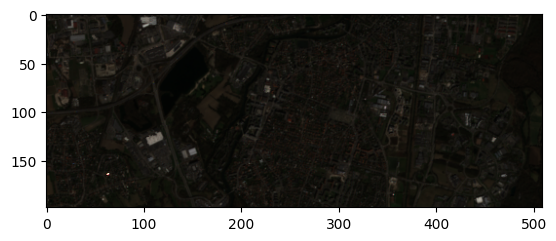

In [19]:
true_color_imgs = request_true_color.get_data()

for img in true_color_imgs:
    plt.imshow(img)
    plt.show()


In [11]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (198, 509, 3)


Image type: uint8


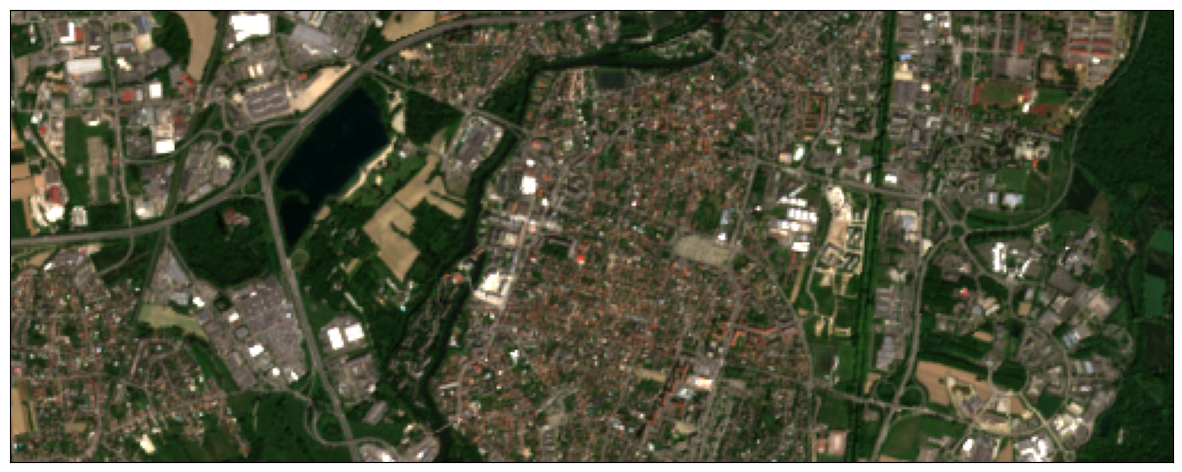

In [14]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

### Example 2: NDVI Image

Secondly, we will also show you an example of how to calculate and visualise NDVI using the same API. NDVI is a very commonly used spectral vegetation index for vegetation monitoring, for example, monitoring crop growth and yields. As you will notice in the codeblock below, the evalscript has changed substantially:
- we are only using Band 4 and Band 8 as an input into our script.
- In the `evaluatePixel()` function, we calculate NDVI and visualise this using the `imgVals` array. 

In [14]:
evalscript_ndvi = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 4
    }
  }
}
  

function evaluatePixel(sample) {
    let val = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
    let imgVals = null;
    
    if (val<-1.1) imgVals = [0,0,0];
    else if (val<-0.2) imgVals = [0.75,0.75,0.75];
    else if (val<-0.1) imgVals = [0.86,0.86,0.86];
    else if (val<0) imgVals = [1,1,0.88];
    else if (val<0.025) imgVals = [1,0.98,0.8];
    else if (val<0.05) imgVals = [0.93,0.91,0.71];
    else if (val<0.075) imgVals = [0.87,0.85,0.61];
    else if (val<0.1) imgVals = [0.8,0.78,0.51];
    else if (val<0.125) imgVals = [0.74,0.72,0.42];
    else if (val<0.15) imgVals = [0.69,0.76,0.38];
    else if (val<0.175) imgVals = [0.64,0.8,0.35];
    else if (val<0.2) imgVals = [0.57,0.75,0.32];
    else if (val<0.25) imgVals = [0.5,0.7,0.28];
    else if (val<0.3) imgVals = [0.44,0.64,0.25];
    else if (val<0.35) imgVals = [0.38,0.59,0.21];
    else if (val<0.4) imgVals = [0.31,0.54,0.18];
    else if (val<0.45) imgVals = [0.25,0.49,0.14];
    else if (val<0.5) imgVals = [0.19,0.43,0.11];
    else if (val<0.55) imgVals = [0.13,0.38,0.07];
    else if (val<0.6) imgVals = [0.06,0.33,0.04];
    else imgVals = [0,0.27,0];
    
    
    imgVals.push(sample.dataMask)
    
    return imgVals
}
"""

request_ndvi_img = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2022-05-01", "2022-05-20"),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

The same method as before is used to request and then visualise the data. In the visualisation, the lighter greens indicate a higher NDVI value (vegetation, forest) and the darker greens (urban areas and water bodies) represent areas with lower NDVI values.

In [15]:
ndvi_img = request_ndvi_img.get_data()

In [16]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (1054, 860, 3)


Image type: uint8


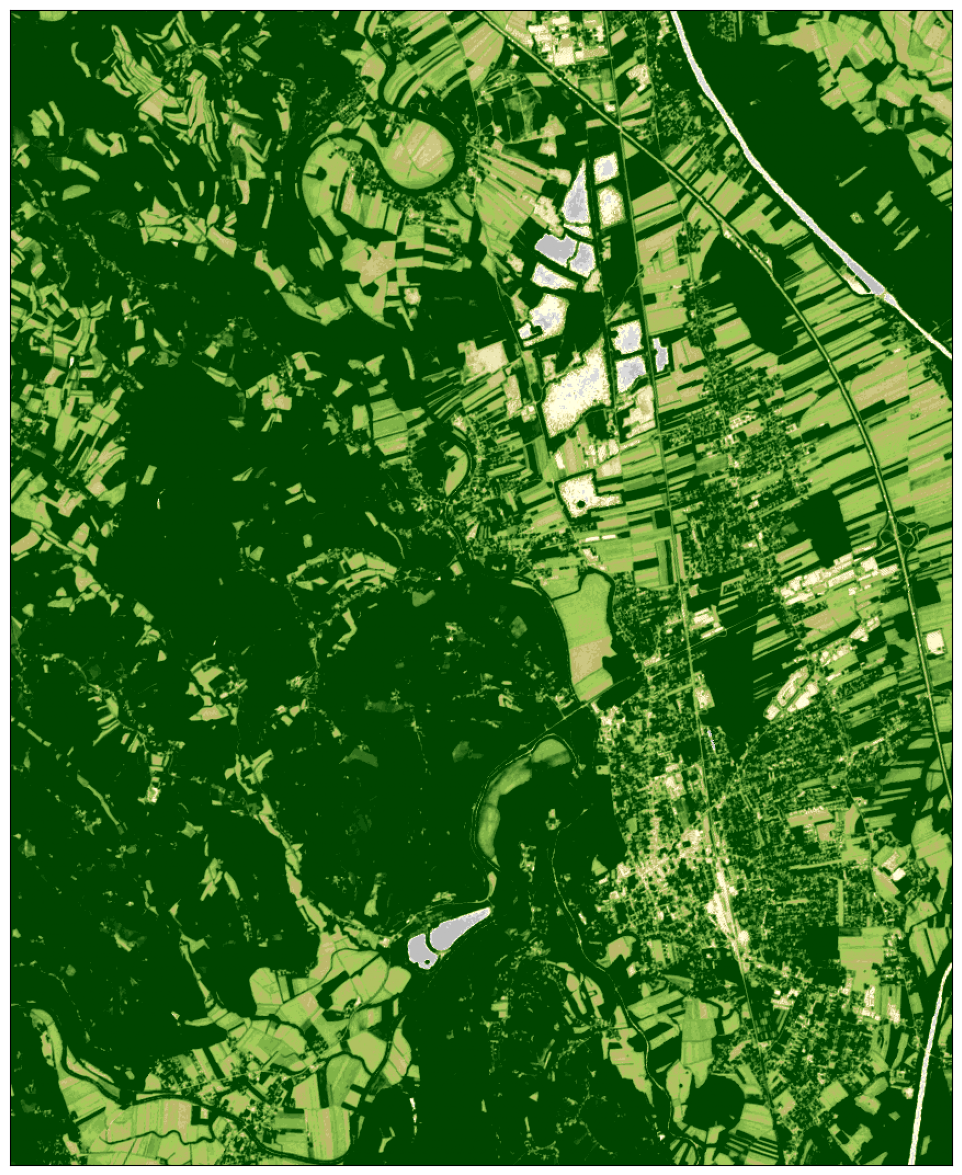

In [17]:
image = ndvi_img[0]
print(f"Image type: {image.dtype}")

# plot function
plot_image(image, factor=1 / 255)

## Statistical API

In the Process API examples, we have seen how to obtain satellite imagery. Statistical API can be used in a very similar way. The main difference is that the results of Statistical API are aggregated statistical values of satellite data instead of entire images. In many use cases, such values are all that we need. By using Statistical API we can avoid downloading and processing large amounts of satellite data.

All general rules for building evalscripts apply. However, there are some specifics when using evalscripts with the Statistical API:

- The `evaluatePixel()` function must, in addition to other output, always return a `dataMask` output. This output defines which pixels are excluded from calculations. For more details and an example, see [here](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical.html).
- The default value of sampleType is `FLOAT32`.
- The output.bands parameter in the setup() function can be an array. This makes it possible to specify custom names for the output bands and different output `dataMask` for different outputs, see this [example](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical/Examples.html#multiple-outputs-with-different-datamasks-multi-band-output-with-custom-bands-names-and-different-histogram-types).

### Requesting, and plotting an NDVI time series for a single field

In the example here, we will calculate NDVI for a specific field of interest and then plot the mean NDVI and standard deviation over the requested time period. First we define our evalscript:

In [18]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "ndvi",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    let index = (samples.B08 - samples.B04) / (samples.B08+samples.B04);
    return {
        ndvi: [index],
        dataMask: [samples.dataMask],
    };
}

"""

In this example, we will compare two fields within the area we requested using Process API:

In [19]:
field1 = {
    "type": "Polygon",
    "coordinates": [
        [
            [15.541723001099184, 46.820368115848446],
            [15.541756949727985, 46.82037740810231],
            [15.54192669287196, 46.82008470133467],
            [15.542211861353849, 46.81964331510048],
            [15.539394125163792, 46.81905789197882],
            [15.539251540922846, 46.819805931503055],
            [15.541723001099184, 46.820368115848446],
        ]
    ],
}

field2 = {
    "type": "Polygon",
    "coordinates": [
        [
            [15.507170086710744, 46.83938135202761],
            [15.508086699688228, 46.83921879483953],
            [15.50831755036404, 46.839576420004114],
            [15.508582349668648, 46.83992939835186],
            [15.508874307876296, 46.840221997066486],
            [15.50860950857169, 46.840514594187695],
            [15.50842618597619, 46.84082112279607],
            [15.508113858591262, 46.840639992466144],
            [15.50781511065786, 46.84039384001332],
            [15.50739414766079, 46.83981328730921],
            [15.507149717533464, 46.83939064099493],
            [15.507170086710744, 46.83938135202761],
        ]
    ],
}

Now we have defined the evalscript and the two fields of interest, we can build the first Statistical API Request, before returning the response for the first field. In this request, as part of the payload we define some input parameters:
- `time_interval` this defines the time range of our request.
- `aggregation_interval` this defines the length of time each interval is. In this case, the interval is 10 days. he aggregation intervals should be at least one day long (e.g. "P5D", "P30D"). You can only use period OR time designator not both. 
- `dataFilter: {maxCloudCoverage}` this is an additional argument in our request which filters out image acquisitions that have a cloud coverage percentage above 10%.

**NOTE:**
If a timeRange is not divisible by an aggregationInterval, the last ("not full") time interval will be dismissed by default (SKIP option). The user can instead set the lastIntervalBehavior to SHORTEN (shortens the last interval so that it ends at the end of the provided time range) or EXTEND (extends the last interval over the end of the provided time range so that all the intervals are of equal duration).

In [20]:
geometry = Geometry(geometry=field1, crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=("2022-04-01T00:00:00Z", "2022-08-30T23:59:59Z"),
        aggregation_interval="P10D",
        size=[368.043, 834.345],
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L1C.define_from(
                name="s2l1c", service_url="https://sh.dataspace.copernicus.eu"
            ),
            other_args={"dataFilter": {"maxCloudCoverage": 10}},
        ),
    ],
    geometry=geometry,
    config=config,
)

response1 = request.get_data()
response1

[{'data': [{'interval': {'from': '2022-04-21T00:00:00Z',
     'to': '2022-05-01T00:00:00Z'},
    'outputs': {'ndvi': {'bands': {'B0': {'stats': {'min': 0.08251231163740158,
         'max': 0.4008755385875702,
         'mean': 0.12654440166065492,
         'stDev': 0.055473709512438456,
         'sampleCount': 306912,
         'noDataCount': 137731}}}}}},
   {'interval': {'from': '2022-05-11T00:00:00Z', 'to': '2022-05-21T00:00:00Z'},
    'outputs': {'ndvi': {'bands': {'B0': {'stats': {'min': 0.07623080909252167,
         'max': 0.4369296729564667,
         'mean': 0.11642366823286553,
         'stDev': 0.0579262529895709,
         'sampleCount': 306912,
         'noDataCount': 137731}}}}}},
   {'interval': {'from': '2022-05-21T00:00:00Z', 'to': '2022-05-31T00:00:00Z'},
    'outputs': {'ndvi': {'bands': {'B0': {'stats': {'min': 0.12066936492919922,
         'max': 0.22302666306495667,
         'mean': 0.16241381213255351,
         'stDev': 0.021031475729827318,
         'sampleCount': 30

However, as it is clear to see, our response is not that useful in `json` format. It's difficult to read from a human perspective. So, let's transform it into a `pandas` dataframe. To help us achieve this, let's define some helper functions. 

In [21]:
# define functions to extract statistics for all acquisition dates
def extract_stats(date, stat_data):
    d = {}
    for key, value in stat_data["outputs"].items():
        stats = value["bands"]["B0"]["stats"]
        if stats["sampleCount"] == stats["noDataCount"]:
            continue
        else:
            d["date"] = [date]
            for stat_name, stat_value in stats.items():
                if stat_name == "sampleCount" or stat_name == "noDataCount":
                    continue
                else:
                    d[f"{key}_{stat_name}"] = [stat_value]
    return pd.DataFrame(d)


def read_acquisitions_stats(stat_data):
    df_li = []
    for aq in stat_data:
        date = aq["interval"]["from"][:10]
        df_li.append(extract_stats(date, aq))
    return pd.concat(df_li)

In [22]:
result_df1 = read_acquisitions_stats(response1[0]["data"])
result_df1

,date,ndvi_min,ndvi_max,ndvi_mean,ndvi_stDev
0,2022-04-21,0.082512,0.400876,0.126544,0.055474
0,2022-05-11,0.076231,0.436930,0.116424,0.057926
0,2022-05-21,0.120669,0.223027,0.162414,0.021031
0,2022-05-31,0.304556,0.563176,0.386850,0.036447
0,2022-06-10,0.503700,0.763252,0.717059,0.036072
0,2022-06-20,0.534064,0.847132,0.814026,0.041844
0,2022-06-30,0.547093,0.816935,0.736540,0.047786
0,2022-07-10,0.477608,0.779166,0.635876,0.036884
0,2022-07-20,0.382375,0.729645,0.478464,0.050253
0,2022-07-30,0.251779,0.680233,0.346311,0.062553


We can take this another step further, and display the data in a time series using the Matplotlib python library:

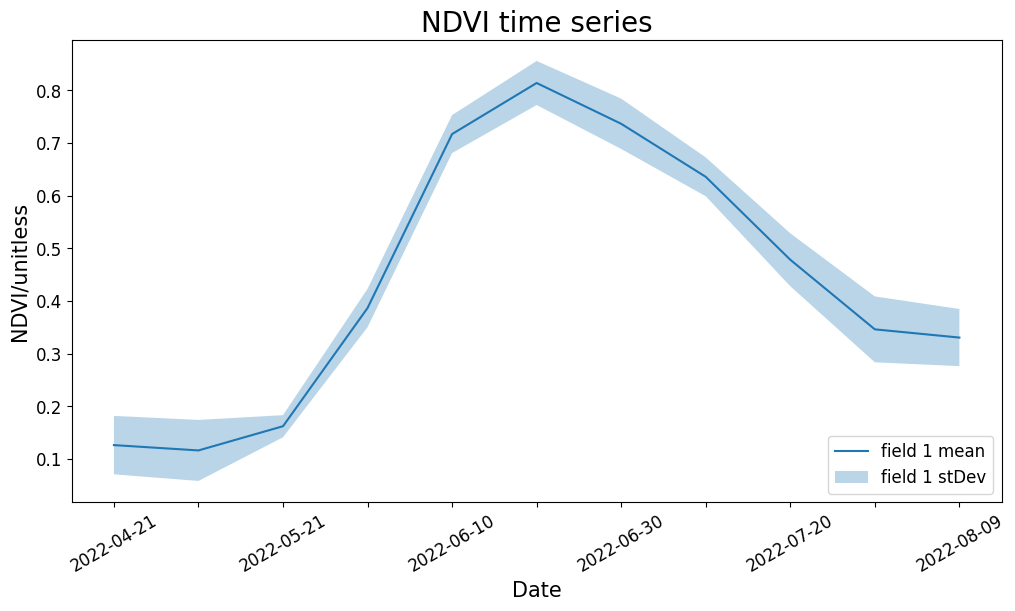

In [23]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(12, 6))
t1 = result_df1["date"]
ndvi_mean_field1 = result_df1["ndvi_mean"]
ndvi_std_field1 = result_df1["ndvi_stDev"]
ax_stat.plot(t1, ndvi_mean_field1, label="field 1 mean")
ax_stat.fill_between(
    t1,
    ndvi_mean_field1 - ndvi_std_field1,
    ndvi_mean_field1 + ndvi_std_field1,
    alpha=0.3,
    label="field 1 stDev",
)
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)
ax_stat.set_xlabel("Date", size=15)
ax_stat.set_ylabel("NDVI/unitless", size=15)
ax_stat.legend(loc="lower right", prop={"size": 12})
ax_stat.set_title("NDVI time series", fontsize=20)
for label in ax_stat.get_xticklabels()[1::2]:
    label.set_visible(False)

### Comparing different fields

Now that we have learnt how to plot the data for the first field, let's take this another step forward and compare the NDVI time series of the first field with the second field. We will now run the same request for our second field and then transform the response into a second Pandas dataframe.

In [24]:
geometry = Geometry(geometry=field2, crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=("2022-04-01T00:00:00Z", "2022-08-30T23:59:59Z"),
        aggregation_interval="P10D",
        size=[368.043, 834.345],
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L1C.define_from(
                name="s2l1c", service_url="https://sh.dataspace.copernicus.eu"
            ),
            other_args={"dataFilter": {"maxCloudCoverage": 10}},
        ),
    ],
    geometry=geometry,
    config=config,
)

response2 = request.get_data()
result_df2 = read_acquisitions_stats(response2[0]["data"])

Now we have requested the statistics for both fields and transformed them into Pandas dataframes, let's plot the two time series and visualise this in the same plot:

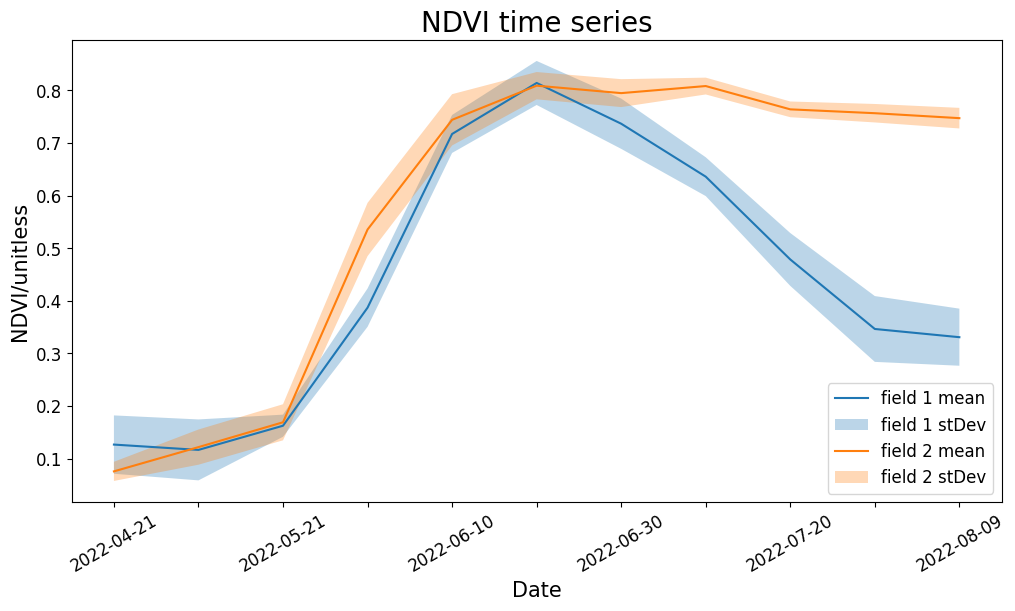

In [25]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(12, 6))
t1 = result_df1["date"]
t2 = result_df1["date"]
ndvi_mean_field1 = result_df1["ndvi_mean"]
ndvi_std_field1 = result_df1["ndvi_stDev"]
ndvi_mean_field2 = result_df2["ndvi_mean"]
ndvi_std_field2 = result_df2["ndvi_stDev"]
ax_stat.plot(t1, ndvi_mean_field1, label="field 1 mean")
ax_stat.fill_between(
    t1,
    ndvi_mean_field1 - ndvi_std_field1,
    ndvi_mean_field1 + ndvi_std_field1,
    alpha=0.3,
    label="field 1 stDev",
)
ax_stat.plot(t2, ndvi_mean_field2, label="field 2 mean")
ax_stat.fill_between(
    t2,
    ndvi_mean_field2 - ndvi_std_field2,
    ndvi_mean_field2 + ndvi_std_field2,
    alpha=0.3,
    label="field 2 stDev",
)
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)
ax_stat.set_xlabel("Date", size=15)
ax_stat.set_ylabel("NDVI/unitless", size=15)
ax_stat.legend(loc="lower right", prop={"size": 12})
ax_stat.set_title("NDVI time series", fontsize=20)
for label in ax_stat.get_xticklabels()[1::2]:
    label.set_visible(False)

## Summary

So what have we learnt in this notebook?

- How to quickly access satellite imagery though Sentinel Hub using Process API.
- Visualising NDVI derived from the satellite imagery 
- Using Statistical API to produce NDVI time series for single and multiple fields.

This concludes this notebook on working with Sentinel Hub APIs to access data from the Copernicus Data Space Ecosystem. For more information you can check out the [Sentinel Hub API](https://dataspace.copernicus.eu/analyse/apis/sentinel-hub) Documentation and the [Sentinel Hub Python package](https://sentinelhub-py.readthedocs.io/en/latest/index.html) documentation too.